##  Double descent in two layer neural network
From "Early stopping in deep neural networks: double descent and how to eliminate it."

In [1]:
#!/usr/bin/env python
# coding: utf-8

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import argparse
import os
import datetime
import pathlib
import random
import json
import numpy as np
import math

import torch

import sys
sys.path.append('../code/')
from linear_utils import linear_model
from train_utils import save_config, prune_data

In [2]:
np.random.seed(12)
d_out = 1      # dimension of y
d = 10
n = 20
n_test = 1000
kappa = np.sqrt(4 * n) 

# sample training set from the linear model
lin_model = linear_model(d, sigma_noise=1.0, beta=np.ones(d,) * 1, scale_beta=True, normalized=False, sigmas=1.0, kappa=kappa, p=1, s_range=None, transform_data=True)
Xs, ys = lin_model.sample(n)
Xs, ys = torch.Tensor(Xs), torch.Tensor(ys.reshape((-1,1)))

# sample the set for empirical risk calculation
Xt, yt = lin_model.sample(n_test)
Xt, yt = torch.Tensor(Xt), torch.Tensor(yt.reshape((-1,1)))


[[0.1118034]
 [0.1118034]
 [0.1118034]
 [0.1118034]
 [0.1118034]
 [0.1118034]
 [0.1118034]
 [0.1118034]
 [0.1118034]
 [1.       ]]
[8.94427191 8.94427191 8.94427191 8.94427191 8.94427191 8.94427191
 8.94427191 8.94427191 8.94427191 1.        ]
[[-0.00000000e+00  6.88976660e-01 -5.77309682e-01 -1.37592707e-01
   7.09338693e-02  1.66060950e-02  4.00991215e-01 -6.08215943e-02
  -5.73789397e-02 -1.55181049e-16]
 [ 0.00000000e+00 -7.12636496e-02  2.43880330e-02  6.06992081e-01
  -2.01412235e-02 -4.80014455e-01  3.76035737e-01 -3.89042777e-01
   3.19860323e-01  3.27970748e-17]
 [ 0.00000000e+00  1.16761021e-01 -6.96919665e-02 -1.26080022e-02
  -4.59576837e-01 -3.89316715e-01 -3.49843647e-01 -3.71485311e-01
  -5.98481950e-01  1.17168357e-16]
 [ 0.00000000e+00  2.80545489e-02  9.90746915e-03  6.27883493e-02
  -8.47266990e-02  6.66204174e-01 -1.12757057e-01 -7.14609832e-01
   1.44168048e-01  5.84716876e-17]
 [-1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.0

In [3]:
# define loss functions
loss_fn = torch.nn.MSELoss(reduction='mean')
risk_fn = loss_fn

In [4]:
def get_jacobian_two_layer(X, y, model, crit):
    
    grads = []
    for cx, cy in zip(X, y):

        cur_grads = []
        model.zero_grad()
        co = model(cx)
        co.backward(torch.ones(len(cy)))

        for p in model.parameters():
            if p.grad is not None and len(p.data.shape) > 1:
                cur_grads.append(p.grad.data.numpy().flatten())
        grads.append(np.concatenate(cur_grads))
    return np.array(grads)

## Linear model

In [5]:
# Two layer neural network in pytorch
scales = [0.0001] * 2
lr = [0.01] * 2
hidden_dim = 10
its = 50000

model = torch.nn.Sequential(
        torch.nn.Linear(d, hidden_dim, bias=False),
        torch.nn.Identity(),
        torch.nn.Linear(hidden_dim, 1, bias=False),
    )
  

with torch.no_grad():
    i = 0
    for m in model:
        if type(m) == torch.nn.Linear:

            m.weight.data = torch.ones(m.weight.data.shape) * scales[i]
            print(m.weight.data.shape, scales[i])

            i += 1

torch.Size([10, 10]) 0.0001
torch.Size([1, 10]) 0.0001


In [6]:
# compute the Jacobian at initialization
J = get_jacobian_two_layer(Xs, ys, model, loss_fn)
uv, sv, vtv = np.linalg.svd(J)

v1 = []
v2 = []
for i in range(sv.shape[0]):
    v1.append(np.linalg.norm(vtv[i,:][:np.prod([hidden_dim, d])]))
    v2.append(np.linalg.norm(vtv[i,:][-np.prod([1, hidden_dim]):]))
v1 = np.array(v1)
v2 = np.array(v2)
vTrec = np.linalg.norm(np.stack((v1, v2)), axis=0)


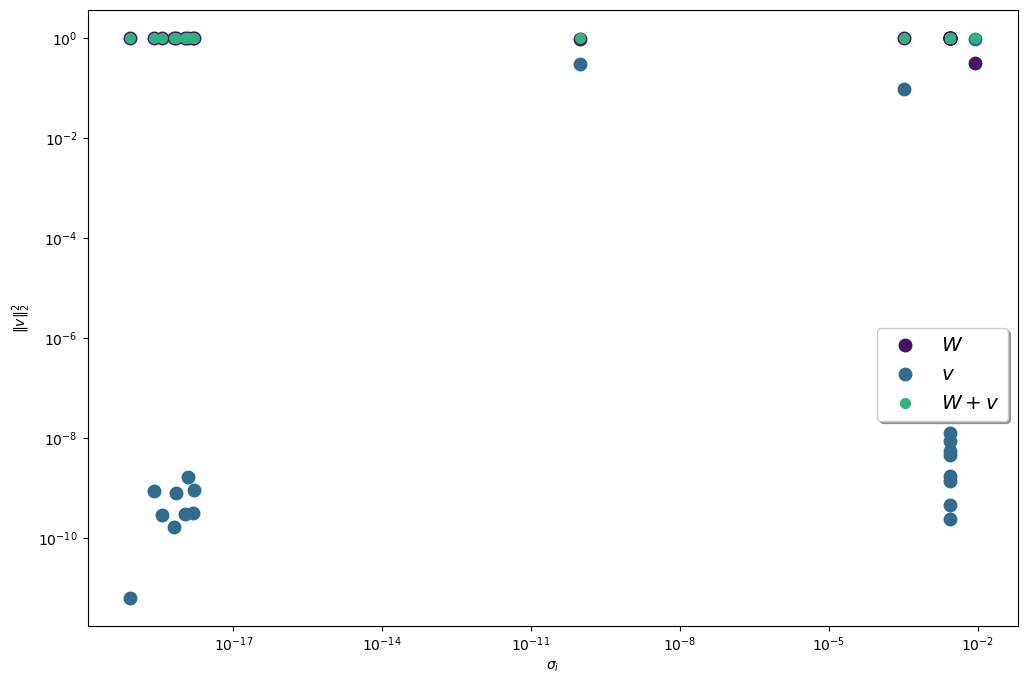

In [7]:
cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000), cmap(650/1000)]
labelList = [r'$W$', r'$v$', r'$W + v$']

fig = plt.figure(figsize=(12,8))

ax_list = [plt.subplot(111)]

ax_list[0].scatter(sv, v1, 
                color=colorList[0], 
                label=labelList[0],
                lw=4)
ax_list[0].scatter(sv, v2, 
                color=colorList[1], 
                label=labelList[1],
#                 ls='dashed',
                lw=4)
ax_list[0].scatter(sv, vTrec, 
                color=colorList[2], 
                label=labelList[2],
#                 ls='dashed',
                lw=2)
    
ax_list[-1].legend(loc=0, bbox_to_anchor=(1, 0.5), fontsize='x-large',
                   frameon=True, fancybox=True, shadow=True, ncol=1)
ax_list[0].set_ylabel(r'$\Vert v \Vert_2^2$')

# for i, ax in enumerate(ax_list): ax.set_title(r'$w = $' + str(weights[i]['w']) + 
#                                               r';$v = $' + str(weights[i]['v']))
for ax in ax_list: ax.set_xlabel(r'$\sigma_i$')
for ax in ax_list: ax.set_xscale('log')
for ax in ax_list: ax.set_yscale('log')
plt.show()

In [492]:
losses_lin = []
risks_lin = []
weights_lin = []

print_freq = 1000
for t in range(int(its)):
    y_pred = model(Xs)

    loss = loss_fn(y_pred, ys)
    losses_lin.append(loss.item())

    if not t % print_freq:
        print(t, loss.item())
        
    with torch.no_grad():
        yt_pred = model(Xt)
        
        risk = risk_fn(yt_pred, yt)
        risks_lin.append(risk.item())

        if not t % print_freq:
            print(t, risk.item())
        
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        i = 0
        
        w = None
        for param in model.parameters():
            
            if len(param.shape) > 1:
                if i == 0:
                    w = param.data.T.clone().detach()
                else:
                    w = w @ param.data.T.clone().detach()
                    
                param.data -= lr[i] * param.grad            
                i += 1
                
        weights_lin.append(w.numpy().squeeze())
            

0 1.947353720664978
0 1.0150212049484253
1000 0.7159972190856934
1000 1.010708212852478
2000 0.6892482042312622
2000 1.009188175201416
3000 0.6887696385383606
3000 1.0090405941009521
4000 0.6887672543525696
4000 1.009030818939209
5000 0.6887672543525696
5000 1.0090301036834717
6000 0.6887672543525696
6000 1.0090301036834717
7000 0.6887672543525696
7000 1.0090301036834717
8000 0.6887672543525696
8000 1.0090301036834717
9000 0.6887672543525696
9000 1.0090301036834717
10000 0.6887672543525696
10000 1.0090301036834717
11000 0.6887672543525696
11000 1.0090301036834717
12000 0.6887672543525696
12000 1.0090301036834717
13000 0.6887672543525696
13000 1.0090301036834717
14000 0.6887672543525696
14000 1.0090301036834717
15000 0.6887672543525696
15000 1.0090301036834717
16000 0.6887672543525696
16000 1.0090301036834717
17000 0.6887672543525696
17000 1.0090301036834717
18000 0.6887672543525696
18000 1.0090301036834717
19000 0.6887672543525696
19000 1.0090301036834717
20000 0.6887672543525696
20000

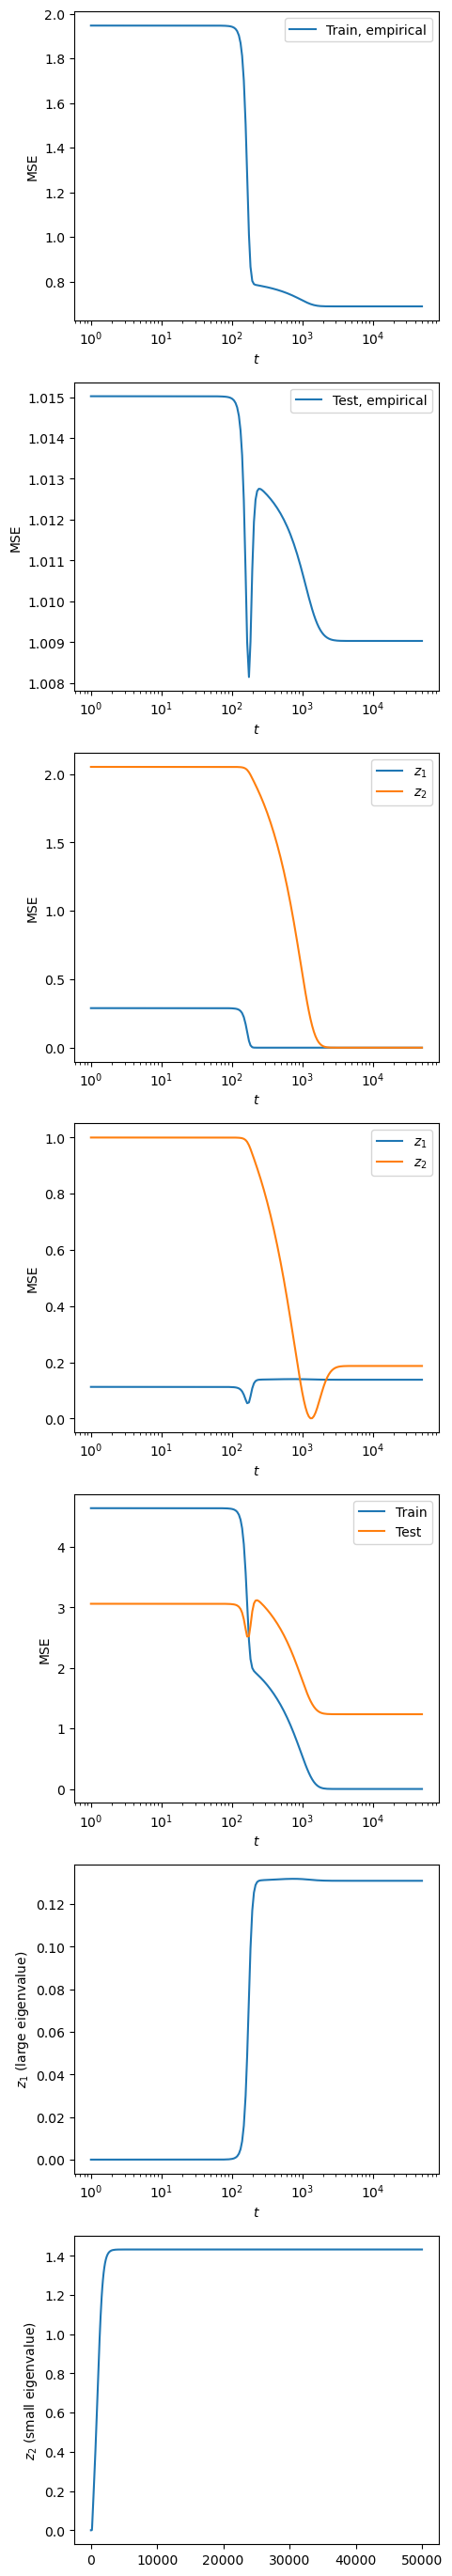

In [562]:
losses = np.array(losses_lin)
risks = np.array(risks_lin)

w_min = (ys.T @ Xs @ np.linalg.inv(Xs.T@Xs)).numpy().squeeze()
losses_w = np.array([(w_min - w)**2 for w in weights_lin])
risks_w = np.array([(lin_model.beta.squeeze() - w)**2 for w in weights_lin])
ws = np.array(weights_lin)

geo_samples = [int(i) for i in np.geomspace(1, len(risks)-1, num=200)]

cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000)]
labelList = ['same stepsize', 'scaled stepsize']

fig, ax = plt.subplots(7, 1, figsize=(5, 35))

ax[0].plot(geo_samples, losses[geo_samples], label="Train, empirical")
ax[1].plot(geo_samples, risks[geo_samples], label="Test, empirical")

ax[2].plot(geo_samples, losses_w[geo_samples, :-1].sum(axis=-1), label=fr"$z_1$")
ax[2].plot(geo_samples, losses_w[geo_samples, -1], label=fr"$z_2$")

ax[3].plot(geo_samples, risks_w[geo_samples, :-1].sum(axis=-1), label=fr"$z_1$")
ax[3].plot(geo_samples, risks_w[geo_samples, -1], label=fr"$z_2$")

ax[4].plot(geo_samples, (losses_w[geo_samples, :-1].sum(axis=-1) * kappa + losses_w[geo_samples, -1]), label="Train")
ax[4].plot(geo_samples, (risks_w[geo_samples, :-1].sum(axis=-1) * kappa + losses_w[geo_samples, -1]), label="Test")

ax[5].plot(geo_samples, ws[geo_samples, :-1].mean(axis=-1))
ax[6].plot(geo_samples, ws[geo_samples, -1])


for i in range(6):
    ax[i].set_xscale('log')
    
    if i < 5:
        ax[i].legend()
        ax[i].set_ylabel('MSE')
    
    ax[i].set_xlabel(r'$t$')

ax[5].set_ylabel(fr"$z_1$ (large eigenvalue)")
ax[6].set_ylabel(fr"$z_2$ (small eigenvalue)")

plt.show()

# ReLU-model

In [11]:
# Two layer neural network in pytorch
lr = [0.001] * 2
its = 100000

model = torch.nn.Sequential(
        torch.nn.Linear(d, hidden_dim, bias=False),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, 1, bias=False),
    )
  

with torch.no_grad():
    i = 0
    for m in model:
        if type(m) == torch.nn.Linear:

            m.weight.data = torch.ones(m.weight.data.shape) * scales[i]
            print(m.weight.data.shape, scales[i])

            i += 1

torch.Size([10, 10]) 0.0001
torch.Size([1, 10]) 0.0001


In [12]:
# compute the Jacobian at initialization
J = get_jacobian_two_layer(Xs, ys, model, loss_fn)
uv, sv, vtv = np.linalg.svd(J)

v1 = []
v2 = []
for i in range(sv.shape[0]):
    v1.append(np.linalg.norm(vtv[i,:][:np.prod([250, 50])]))
    v2.append(np.linalg.norm(vtv[i,:][-np.prod([1, 250]):]))
v1 = np.array(v1)
v2 = np.array(v2)
vTrec = np.linalg.norm(np.stack((v1, v2)), axis=0)


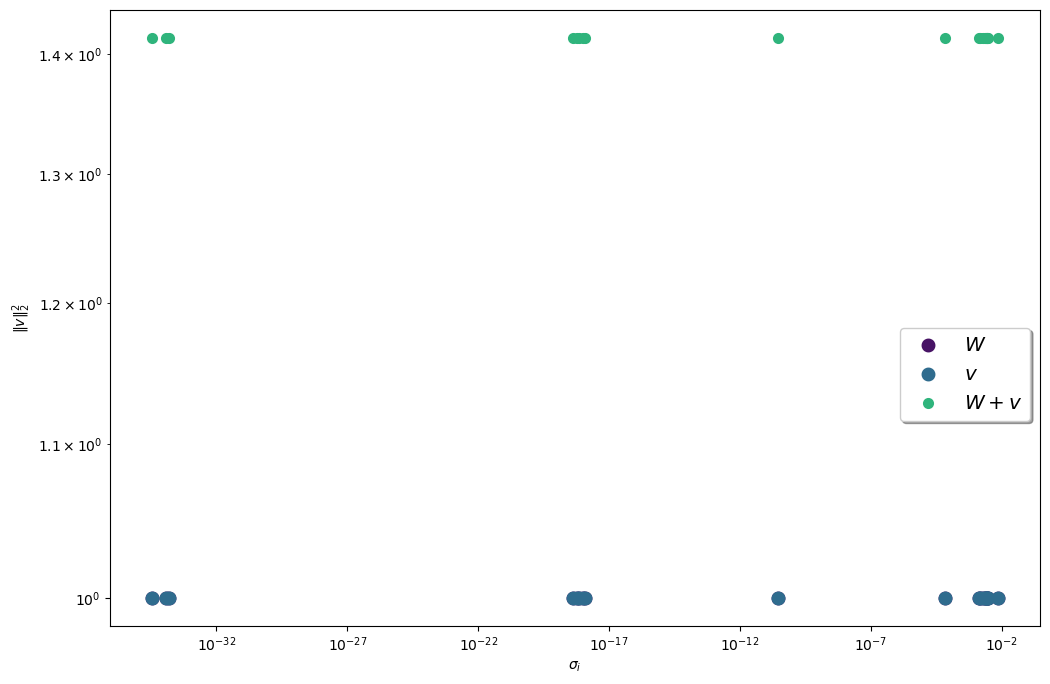

In [13]:
cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000), cmap(650/1000)]
labelList = [r'$W$', r'$v$', r'$W + v$']

fig = plt.figure(figsize=(12,8))

ax_list = [plt.subplot(111)]

ax_list[0].scatter(sv, v1, 
                color=colorList[0], 
                label=labelList[0],
                lw=4)
ax_list[0].scatter(sv, v2, 
                color=colorList[1], 
                label=labelList[1],
#                 ls='dashed',
                lw=4)
ax_list[0].scatter(sv, vTrec, 
                color=colorList[2], 
                label=labelList[2],
#                 ls='dashed',
                lw=2)
    
ax_list[-1].legend(loc=0, bbox_to_anchor=(1, 0.5), fontsize='x-large',
                   frameon=True, fancybox=True, shadow=True, ncol=1)
ax_list[0].set_ylabel(r'$\Vert v \Vert_2^2$')

# for i, ax in enumerate(ax_list): ax.set_title(r'$w = $' + str(weights[i]['w']) + 
#                                               r';$v = $' + str(weights[i]['v']))
for ax in ax_list: ax.set_xlabel(r'$\sigma_i$')
for ax in ax_list: ax.set_xscale('log')
for ax in ax_list: ax.set_yscale('log')
plt.show()

In [524]:
losses_nonlin = []
risks_nonlin = []
weights_nonlin = []

print_freq = 1000
for t in range(int(its)):
    y_pred = model(Xs)

    loss = loss_fn(y_pred, ys)
    losses_nonlin.append(loss.item())

    if not t % print_freq:
        print(t, loss.item())
        
    with torch.no_grad():
        yt_pred = model(Xt)
        
        risk = risk_fn(yt_pred, yt)
        risks_nonlin.append(risk.item())

        if not t % print_freq:
            print(t, risk.item())
        
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        i = 0
        
        w = []
        for param in model.parameters():
            w.append(param.data.T.clone().numpy().reshape(-1))

            if len(param.shape) > 1:
                param.data -= lr[i] * param.grad            

        weights_nonlin.append(np.concatenate(w))

                
            

0 1.9473540782928467
0 1.0150212049484253
1000 1.9471204280853271
1000 1.015019416809082
2000 1.8566961288452148
2000 1.0144203901290894
3000 1.204880952835083
3000 1.0112074613571167
4000 1.1864768266677856
4000 1.0104951858520508
5000 1.1851158142089844
5000 1.0109039545059204
6000 1.184009313583374
6000 1.0113717317581177
7000 1.1830856800079346
7000 1.0117613077163696
8000 1.1823570728302002
8000 1.0120855569839478
9000 1.1816432476043701
9000 1.012352466583252
10000 1.1810007095336914
10000 1.0125924348831177
11000 1.180228352546692
11000 1.012772560119629
12000 1.1796796321868896
12000 1.0129170417785645
13000 1.178970456123352
13000 1.0130267143249512
14000 1.1784441471099854
14000 1.0131311416625977
15000 1.1776361465454102
15000 1.01320481300354
16000 1.177045464515686
16000 1.0132718086242676
17000 1.176263451576233
17000 1.0133308172225952
18000 1.175735354423523
18000 1.013389229774475
19000 1.175018072128296
19000 1.013415813446045
20000 1.1741853952407837
20000 1.01346266

In [544]:
j = np.random.normal(4, size=(5, 3))
print(j)

print(j.T.reshape(-1))



[[2.9082992  2.62745326 4.23028201]
 [3.88071774 3.3648675  4.7893027 ]
 [3.85417263 4.5676294  2.2035514 ]
 [4.3117183  4.82639645 2.32777369]
 [3.65166166 4.31981221 4.77884283]]
[2.9082992  3.88071774 3.85417263 4.3117183  3.65166166 2.62745326
 3.3648675  4.5676294  4.82639645 4.31981221 4.23028201 4.7893027
 2.2035514  2.32777369 4.77884283]


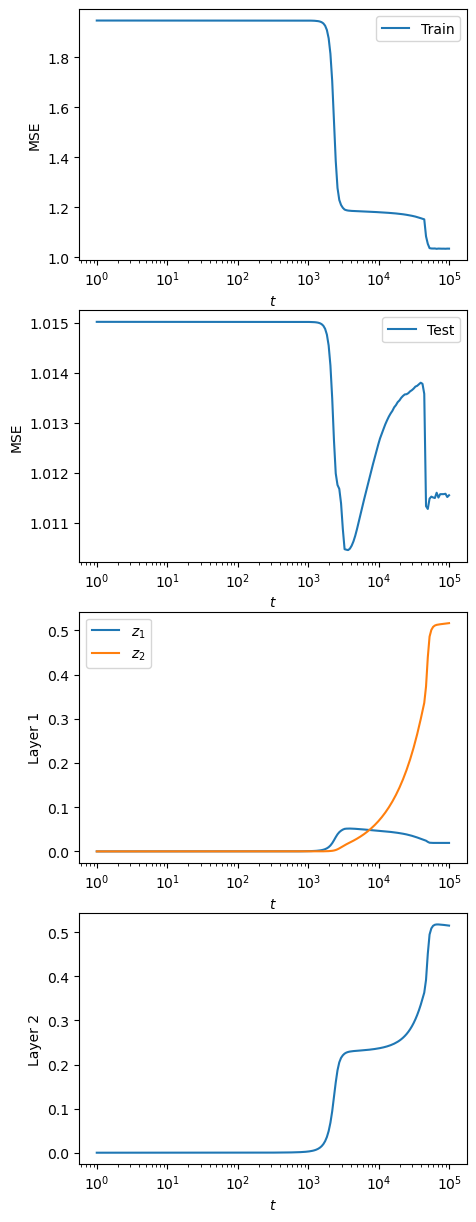

In [559]:
losses = np.array(losses_nonlin)
risks = np.array(risks_nonlin)
ws = np.array(weights_nonlin)

geo_samples = [int(i) for i in np.geomspace(1, len(risks)-1, num=200)]

cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000)]
labelList = ['same stepsize', 'scaled stepsize']

fig, ax = plt.subplots(4, 1, figsize=(5, 15))

ax[0].plot(geo_samples, losses[geo_samples], label="Train")
ax[1].plot(geo_samples, risks[geo_samples], label="Test")

ws_lay_1, ws_lay_2 = ws[:, :(d * hidden_dim)], ws[:, (d * hidden_dim):]
ax[2].plot(geo_samples, ws_lay_1[geo_samples, :((d-1) * hidden_dim)].mean(axis=-1), label=fr"$z_1$")
ax[2].plot(geo_samples, ws_lay_1[geo_samples, ((d-1) * hidden_dim):(d * hidden_dim)].mean(axis=-1), label=fr"$z_2$")
ax[3].plot(geo_samples, ws_lay_2[geo_samples, :].mean(axis=-1))


for i in range(4):
    ax[i].set_xscale('log')
    
    if i < 2:
        ax[i].legend()
        ax[i].set_ylabel('MSE')
        
    ax[i].set_xlabel(r'$t$')
    
ax[2].legend()
ax[2].set_ylabel('Layer 1')
ax[3].set_ylabel('Layer 2')

plt.show()